# Enhanced Comparative Analysis of INS: GPS Prediction from IMU Data

This notebook performs a comprehensive comparison of various machine learning models for predicting GPS coordinates from IMU (Inertial Measurement Unit) data when GPS signals are unavailable.

We'll implement and compare multiple models including:
- Deep Learning Models: LSTM, CNN+LSTM, Transformer, ResNet1D
- Traditional ML Models: SVR, Random Forest, XGBoost, Gradient Boosting
- Ensemble Models

The analysis includes advanced evaluation metrics and visualizations specifically designed for geospatial trajectory prediction.

## 1. Setup & Imports

In [84]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from math import sqrt

# Install required packages if needed
!pip install -q tensorflow scikit-learn xgboost haversine seaborn

# For pretty plots
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Import from other modules
from dataset_loader import load_dataset, split_dataset
from preprocessing import preprocess_data
from kalman_filter import apply_kalman_filter

# Import enhanced models and evaluation functions
from enhanced_ml_models import get_model, reshape_for_rnn, get_callbacks
from enhanced_evaluation import (
    evaluate_model, plot_trajectory, plot_error_distribution,
    plot_comparison_results, plot_tradeoff_analysis, 
    haversine_distance, drift_per_km
)

# Import TensorFlow but don't show the warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


## 2. Load and Preprocess Data

In [85]:
# Load dataset
dataset_path = "IMU.csv"
df = load_dataset(dataset_path)

# Display dataset info
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())
print("\nDataset summary:")
display(df.describe())

# Extract features and labels
X_train, X_test, y_train, y_test = split_dataset(df)

# Preprocess data
X_train_prep, X_test_prep, scaler = preprocess_data(X_train, X_test)

# Apply Kalman filtering to GPS labels (optional, for baseline)
filtered_positions = apply_kalman_filter(df)

print(f"\nTraining set: {X_train_prep.shape}, Target: {y_train.shape}")
print(f"Testing set: {X_test_prep.shape}, Target: {y_test.shape}")

Dataset shape: (10304, 14)

First few rows:


,time,ax,ay,az,wx,wy,wz,Bx,By,Bz,latitude,longitude,altitude,speed
0,2025-02-13 05:43:04.801000+00:00,-0.2775,0.0240,0.5453,-0.2692,-0.2876,0.0531,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
1,2025-02-13 05:43:04.804000+00:00,-0.2775,0.0240,0.5453,-0.1753,-0.1668,0.1018,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
2,2025-02-13 05:43:04.812000+00:00,-0.0585,-0.1047,0.6579,0.0630,0.0344,0.0687,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
3,2025-02-13 05:43:04.822000+00:00,0.1941,-0.1942,0.6870,0.1577,0.0861,0.0053,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
4,2025-02-13 05:43:04.833000+00:00,0.4528,-0.1449,0.5582,0.2020,0.1025,-0.0629,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0



Dataset summary:


,ax,ay,az,wx,wy,wz,Bx,By,Bz,latitude,longitude,altitude,speed
count,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,1.030400e+04,1.030400e+04,10304.0000,10304.000000,10304.000000,10304.000000,10304.000000
mean,0.023179,-0.105303,0.023924,-0.001318,-0.009015,-0.028880,-3.092490e+01,2.902500e+01,-25.3177,12.861894,77.664675,911.824946,0.119759
std,0.763107,0.606263,0.928822,0.313035,0.246759,0.471628,3.552886e-15,7.105772e-15,0.0000,0.000047,0.000041,7.742956,0.675668
min,-4.381300,-3.798800,-4.276000,-3.252200,-2.322800,-2.315500,-3.092490e+01,2.902500e+01,-25.3177,12.861801,77.664573,907.067200,-1.000000
25%,-0.210525,-0.240825,-0.307200,-0.082025,-0.067400,-0.110800,-3.092490e+01,2.902500e+01,-25.3177,12.861859,77.664637,907.295400,0.000000
50%,0.005750,-0.040600,-0.003700,-0.003400,-0.003400,-0.004050,-3.092490e+01,2.902500e+01,-25.3177,12.861892,77.664683,907.301500,0.358600
75%,0.237125,0.103150,0.276300,0.076300,0.057000,0.094300,-3.092490e+01,2.902500e+01,-25.3177,12.861940,77.664704,925.007900,0.594325
max,4.234700,2.417600,8.981600,2.884100,1.930600,2.929100,-3.092490e+01,2.902500e+01,-25.3177,12.861981,77.664766,925.532200,1.388500



Training set: (8243, 9), Target: (8243, 2)
Testing set: (2061, 9), Target: (2061, 2)


## 3. Prepare Sequence Data for RNN-based Models

In [86]:
# Convert data to sequences for RNN models
timesteps = 10
X_train_seq = reshape_for_rnn(X_train_prep, timesteps=timesteps)
X_test_seq = reshape_for_rnn(X_test_prep, timesteps=timesteps)
y_train_seq = y_train[timesteps:]
y_test_seq = y_test[timesteps:]

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
print(f"Input shape for sequence models: {input_shape}")

Input shape for sequence models: (10, 9)


## 4. Define Model Evaluation Function

In [87]:
def evaluate_deep_model(model_name, X_train, y_train, X_test, y_test, 
                        epochs=50, batch_size=32, is_sequence_model=True):
    """Train and evaluate a model with timing and detailed metrics."""
    
    print(f"\n{'='*50}\nTraining {model_name}...\n{'='*50}")
    
    # Get the model
    if is_sequence_model:
        model = get_model(model_name, input_shape)
    else:
        model = get_model(model_name)
    
    # Setup callbacks
    callbacks = get_callbacks()
    
    # Train with timing
    start_time = time.time()
    
    if model_name == "ensemble":
        # For the ensemble model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                 validation_split=0.1, verbose=1)
    elif is_sequence_model:
        # For deep learning sequence models
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=1, callbacks=callbacks)
    elif model_name in ["xgboost", "gradient_boosting", "knn", "random_forest", "svr"]:
        # For traditional ML models
        model.fit(X_train, y_train)
        
    training_time = time.time() - start_time
    
    # Predict with timing
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Evaluate and plot
    metrics = evaluate_model(y_test, y_pred, model_name, 
                           inference_time=inference_time,
                           training_time=training_time)
    
    return model, y_pred, metrics

## 5. Train and Evaluate Deep Learning Models

### 5.1 Bidirectional LSTM

In [88]:
lstm_model, lstm_preds, lstm_metrics = evaluate_deep_model(
    "lstm", X_train_seq, y_train_seq, X_test_seq, y_test_seq,
    epochs=50, batch_size=32, is_sequence_model=True
)



# Store results
results = [lstm_metrics]


Training lstm...
Epoch 1/50


c:\Users\G15\Desktop\coding\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1813.1080 - val_loss: 0.5003 - learning_rate: 0.0010
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 56.5692 - val_loss: 0.8904 - learning_rate: 0.0010
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 49.1194 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 50.6830 - val_loss: 0.3707 - learning_rate: 0.0010
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 50.6746 - val_loss: 0.5146 - learning_rate: 0.0010
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 47.0502 - val_loss: 0.7439 - learning_rate: 0.0010
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 47.5304 - val_loss: 0.7263 - learning_rate: 0.0010
Epoch 8/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46.6997 - val_loss: 1.3842 - learning_rate: 0.0010
Epoch 9/50
223/232 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45.7734
Epoch 9: ReduceLROnPlateau reducing learning rate to 

### 5.2 CNN + LSTM

In [89]:
cnn_lstm_model, cnn_lstm_preds, cnn_lstm_metrics = evaluate_deep_model(
    "cnn_lstm", X_train_seq, y_train_seq, X_test_seq, y_test_seq,
    epochs=30, batch_size=32, is_sequence_model=True
)


results.append(cnn_lstm_metrics)


Training cnn_lstm...
Epoch 1/30


c:\Users\G15\Desktop\coding\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2936.4019 - val_loss: 1832.9507 - learning_rate: 1.0000e-04
Epoch 2/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1655.9453 - val_loss: 1199.5983 - learning_rate: 1.0000e-04
Epoch 3/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1093.1068 - val_loss: 749.3666 - learning_rate: 1.0000e-04
Epoch 4/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 679.3175 - val_loss: 420.1159 - learning_rate: 1.0000e-04
Epoch 5/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 395.7912 - val_loss: 204.6134 - learning_rate: 1.0000e-04
Epoch 6/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 217.7281 - val_loss: 85.0964 - learning_rate: 1.0000e-04
Epoch 7/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 120.8595 - val_loss: 30.6115 - learning_rate: 1.0000e-04
Epoch 8/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 82.5475 - val_loss: 10.2813 - learning_rate: 1.0000e-04
Epoch 9/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 69.480

### 5.3 Transformer Model

In [90]:
transformer_model, transformer_preds, transformer_metrics = evaluate_deep_model(
    "transformer", X_train_seq, y_train_seq, X_test_seq, y_test_seq,
    epochs=100, batch_size=32, is_sequence_model=True
)


results.append(transformer_metrics)


Training transformer...
Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 2879.9749 - val_loss: 1953.7599 - learning_rate: 1.0000e-04
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1616.7515 - val_loss: 709.2571 - learning_rate: 1.0000e-04
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 528.4022 - val_loss: 124.3167 - learning_rate: 1.0000e-04
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 104.9021 - val_loss: 9.0391 - learning_rate: 1.0000e-04
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 39.5010 - val_loss: 0.7720 - learning_rate: 1.0000e-04
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 33.5452 - val_loss: 0.4408 - learning_rate: 1.0000e-04
Epoch 7/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 33.4376 - val_loss: 0.3221 - learning_rate: 1.0000e-04
Epoch 8/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 33.3160 - val_loss: 0.1952 - learning_rate: 1.0000e-04
Epoch 9/100
232/232 ━━━━━━━━━━━━━

In [92]:
transformer_model.save('transformer_gps_model.h5')

In [94]:
from database import (
    connect_db, init_db, store_csv_to_db, fetch_dataset_df,
    save_model_to_db, list_models
)
conn = connect_db("ins_project.db")
init_db(conn)
model_path = "transformer_gps_model.h5"  # ensure model file exists
save_model_to_db(conn, model_path, name="transformer_gps_model", framework="keras")
print(f"\n[INFO] Model '{model_path}' saved into DB.")


[INFO] Model 'transformer_gps_model.h5' saved into DB.


### 5.4 ResNet1D

In [95]:
resnet_model, resnet_preds, resnet_metrics = evaluate_deep_model(
    "resnet1d", X_train_seq, y_train_seq, X_test_seq, y_test_seq,
    epochs=30, batch_size=32, is_sequence_model=True
)


results.append(resnet_metrics)


Training resnet1d...
Epoch 1/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 875.1022 - val_loss: 1.7287 - learning_rate: 1.0000e-04
Epoch 2/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 30.0893 - val_loss: 1.8236 - learning_rate: 1.0000e-04
Epoch 3/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 24.4363 - val_loss: 7.1468 - learning_rate: 1.0000e-04
Epoch 4/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 20.6798 - val_loss: 1.3432 - learning_rate: 1.0000e-04
Epoch 5/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 19.5671 - val_loss: 11.5092 - learning_rate: 1.0000e-04
Epoch 6/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 18.0347 - val_loss: 12.1270 - learning_rate: 1.0000e-04
Epoch 7/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 16.6980 - val_loss: 13.3110 - learning_rate: 1.0000e-04
Epoch 8/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 16.0011 - val_loss: 22.3532 - learning_rate: 1.0000e-04
Epoch 9/30
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 11

## 7. Comprehensive Comparative Analysis

In [96]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Show detailed comparison table
display(results_df[['model', 'RMSE', 'MAE', 'R2', 'avg_distance_error', 'drift_per_km', 'inference_time', 'training_time']])

,model,RMSE,MAE,R2,avg_distance_error,drift_per_km,inference_time,training_time
0,lstm,0.612156,0.484955,-2.629877e+08,93.197239,1891.752061,0.866203,21.115048
1,cnn_lstm,0.523739,0.440480,-1.933882e+08,80.407410,1632.139375,0.852781,52.044066
2,transformer,0.358455,0.264417,-9.011002e+07,51.799873,1051.452989,0.884043,69.498239
3,resnet1d,1.147584,1.019594,-1.056207e+09,178.451000,3622.264463,1.033549,42.893333


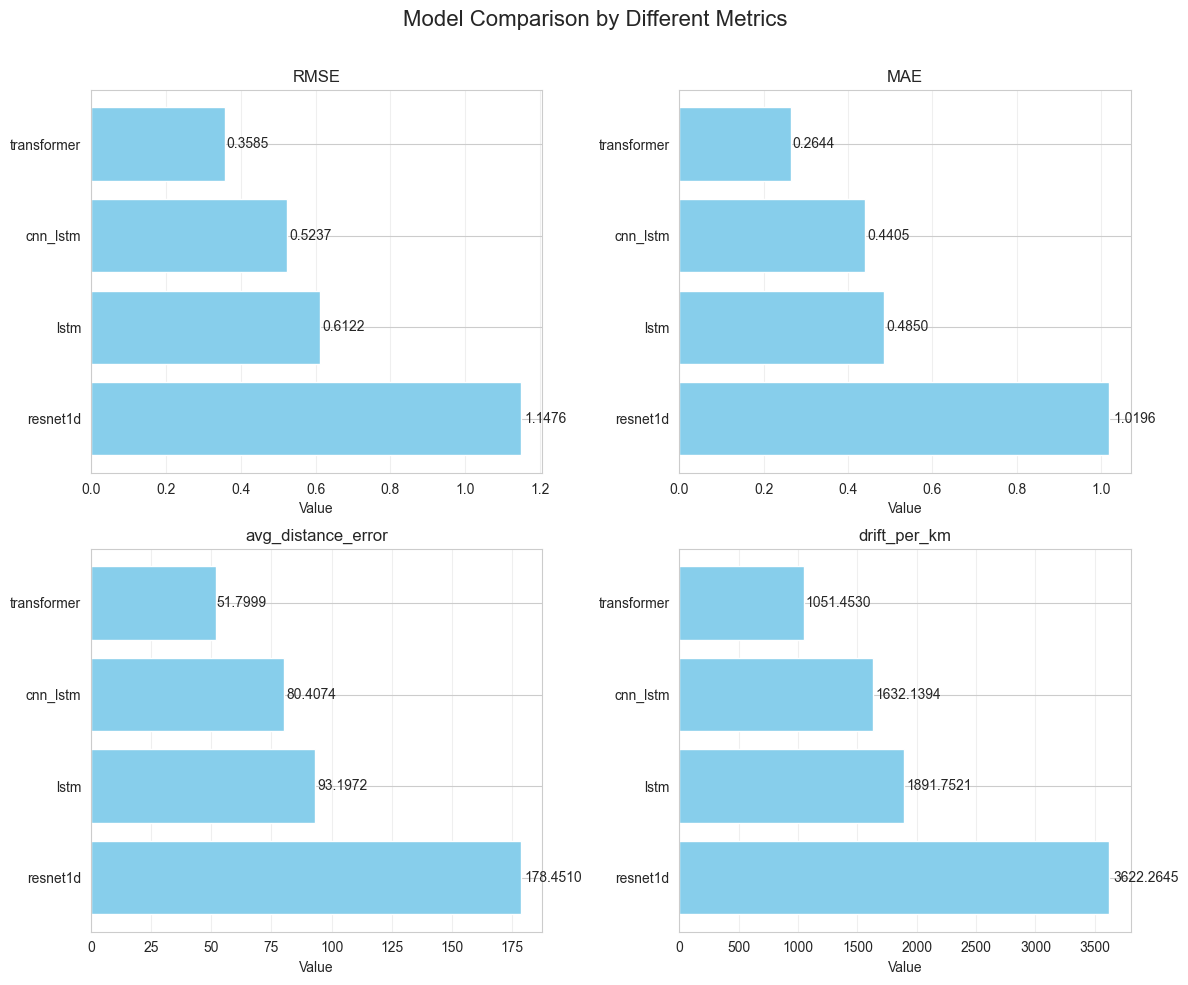

In [97]:
# Plot error metrics comparison
plot_comparison_results(results, metric_columns=['RMSE', 'MAE', 'avg_distance_error', 'drift_per_km'])

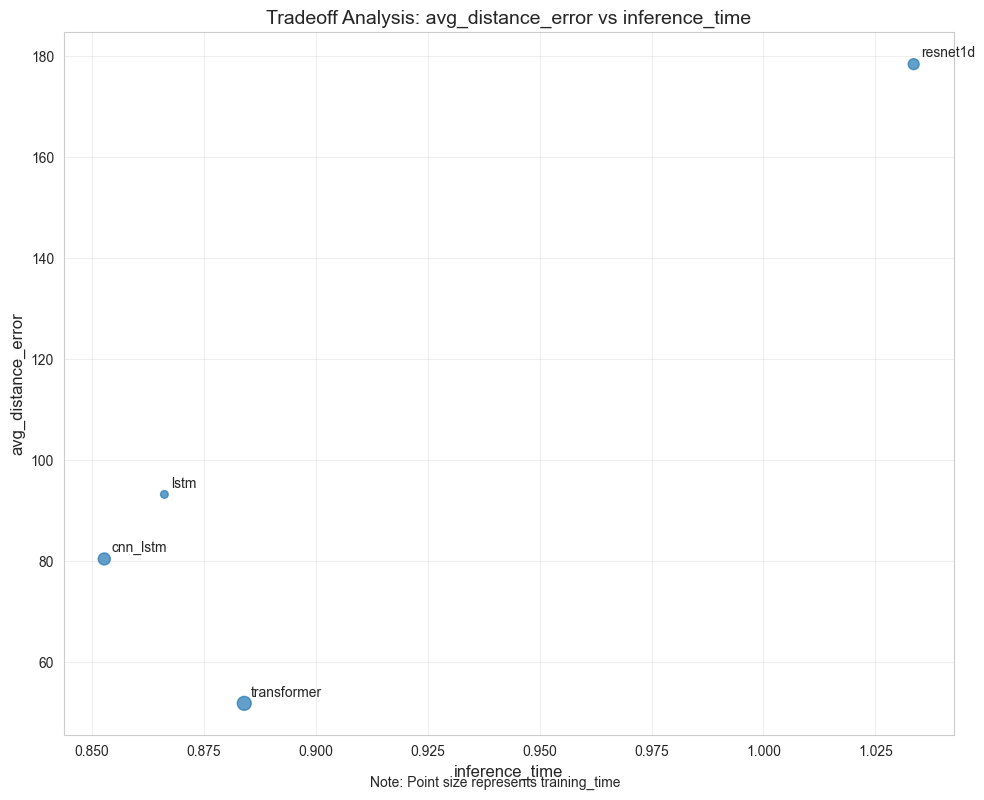

In [98]:
# Plot accuracy vs. latency tradeoff
plot_tradeoff_analysis(results, 
                       x_metric='inference_time', 
                       y_metric='avg_distance_error',
                       size_metric='training_time')

## 8. Error Analysis on Best Model

In [99]:
# Find the best model based on average distance error
best_model_idx = results_df['avg_distance_error'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'model']
print(f"Best model: {best_model_name}")

# Get predictions from best model
best_preds = None
best_y_test = None
if best_model_name == "Bidirectional LSTM":
    best_preds = lstm_preds
    best_y_test = y_test_seq
elif best_model_name == "CNN + LSTM":
    best_preds = cnn_lstm_preds
    best_y_test = y_test_seq
elif best_model_name == "Transformer":
    best_preds = transformer_preds
    best_y_test = y_test_seq
elif best_model_name == "ResNet1D":
    best_preds = resnet_preds
    best_y_test = y_test_seq

# Detailed error analysis on best model
if best_preds is not None and best_y_test is not None:
    # Plot trajectory
    plot_trajectory(best_y_test, best_preds, f"Best Model: {best_model_name}")
    
    # Plot error distribution
    plot_error_distribution(best_y_test, best_preds, f"Best Model: {best_model_name}")

Best model: transformer
